In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.ticker import MultipleLocator
pd.set_option('display.max_columns', None)
import os, requests, time
from google.colab import userdata
fred_api_key=userdata.get('FRED_API_KEY')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# I. Create dataset

## A. Load Functions

In [2]:
def get_children_categories(category_id, api_key, parent_name="ROOT" ):
  store_list=[]
  url="https://api.stlouisfed.org/fred/category/children?"
  params = {
      "api_key":api_key,
      "category_id": category_id,
      "file_type": "json"
  }
  response = requests.get(url, params=params)
  if response.status_code == 200:
    data = response.json()
    children_categories = data.get('categories')
    for children_categorie in children_categories:
      # print(children_categorie)
      child_categori_id = children_categorie.get('id')
      child_name = children_categorie.get("name")
      store_list.append({
            "parent_id": children_categorie.get("parent_id"),
            "parent_name": parent_name,
            "category_id": child_categori_id,
            "name": children_categorie.get("name"),
            "notes": children_categorie.get("notes", "")
        })
  else:
      print(f"Error: {response.status_code}, category: {category_id}")
      return
  df=pd.DataFrame.from_dict(store_list)
  print(df)
  return df

def get_series_from_category(category_id, api_key, filter_term=None):
  store_list=[]
  url="https://api.stlouisfed.org/fred/category/series?"
  params = {
      "api_key":api_key,
      "category_id": category_id,
      "file_type": "json"
  }
  response = requests.get(url, params=params)
  if response.status_code == 200:
    data = response.json()

    series = data.get('seriess')
    for serie in series:
      store_list.append(serie)
      # serie_id = serie.get('id')
      # child_name = serie.get("name")
      # store_list.append({
      #       "parent_id": serie.get("parent_id"),
      #       "parent_name": parent_name,
      #       "category_id": serie_id,
      #       "name": serie.get("name"),
      #       "notes": serie.get("notes", "")
      #   })
  else:
      print(f"Error: {response.status_code}, category: {category_id}")
      return
  df=pd.DataFrame.from_dict(store_list).drop_duplicates('id')
  df.drop(['realtime_start', 'realtime_end','observation_start', 'observation_end','frequency_short', 'units_short',
           'seasonal_adjustment_short','last_updated', 'popularity', 'group_popularity'], axis=1, inplace=True)
  if filter_term:
    df=df[df.title.str.contains(filter_term, case=False, na=False)]
  return df


def search_series(search_name, api_key,frequency_criteria="Monthly", search_term=None):
  SEARCH_URL = f"https://api.stlouisfed.org/fred/series/search?"
  store_list = []
  params = {
      "api_key":api_key,
      "search_text":search_name,
      "file_type": "json"
  }
  response = requests.get(SEARCH_URL, params=params)
  if response.status_code == 200:
    data = response.json()
    # print(data.get("count"))
    series=data.get("seriess")
    for serie in series:
      serie_id = serie.get("id")
      title = serie.get("title")
      frequency=serie.get("frequency")
      note = serie.get("notes")
      unit = serie.get("units")
      if frequency==frequency_criteria:
        store_list.append({"serie_id":serie_id,
                           "title":title,
                           "unit": unit,
                           "notes": note,
                           "seasonal_adjustment":serie.get("seasonal_adjustment")
                           })
  else:
      print(f"Error: {response.status_code}")
      return
  df = pd.DataFrame(store_list)
  if search_term:
    df=df[df.title.str.contains(search_term, case=False, na=False)]
  return df

def get_time_series(serie_id, api_key,start_time="1776-07-04", end_time="9999-12-31",rename=None):
  """return daily time point
  start time: 1776-07-04 is the earliest time
  end time: 9999-12-31 (latest available)
  """
  store_list = []
  URL = f"https://api.stlouisfed.org/fred/series/observations?"
  params = {
      "api_key":api_key,
      "series_id":serie_id,
      "file_type": "json",
      "observation_start": start_time,
      "observation_end": end_time,

  }
  response = requests.get(URL, params=params )
  if response.status_code == 200:
    data = response.json()
    observations = data.get("observations")
    for ob in observations:
      store_list.append({"Date":ob.get("date"), "Value":ob.get("value")})
  else:
      print(f"Error: {response.status_code}")
      return

  res_df = pd.DataFrame(store_list)
  #  Replace '.' with NaN
  res_df['Value'] = pd.to_numeric(res_df['Value'], errors='coerce')
  # Drop rows with NaN in 'value'
  res_df.dropna(subset=['Date','Value'], inplace=True)
  # set DatatimeIndex
  res_df['Date'] = pd.to_datetime(res_df['Date'])
  res_df['Value'] = res_df["Value"].astype(float)
  res_df = res_df.set_index('Date')
  res_df = res_df.sort_index()
  if rename:
    res_df.rename(columns={"Value":rename}, inplace=True)
  return res_df


def get_serie_info(series_name, api_key):
  store_list = []
  URL = f"https://api.stlouisfed.org/fred/series?"
  params = {
      "api_key":api_key,
      "series_id":series_name,
      "file_type": "json",
  }
  response = requests.get(URL, params=params )
  if response.status_code == 200:
    data = response.json()
    data = data.get("seriess")[0]
    df=pd.DataFrame.from_dict(data, orient='index', columns=['Value'])
  else:
      print(f"Error: {response.status_code}")
      return
  print(df)
  return df


## B. Find series name

In [21]:
df=search_series("unemployment+rate", fred_api_key, "Monthly", "Unemployment Rate")

In [22]:
df.head()

,serie_id,title,unit,notes,seasonal_adjustment
0,UNRATE,Unemployment Rate,Percent,The unemployment rate represents the number of...,Seasonally Adjusted
1,UNRATENSA,Unemployment Rate,Percent,The unemployment rate represents the number of...,Not Seasonally Adjusted
2,LNS14000006,Unemployment Rate - Black or African American,Percent,The series comes from the 'Current Population ...,Seasonally Adjusted
3,LNU04000006,Unemployment Rate - Black or African American,Percent,The series comes from the 'Current Population ...,Not Seasonally Adjusted
4,CAUR,Unemployment Rate in California,Percent,None,Seasonally Adjusted


In [23]:
df=search_series("M2", fred_api_key, "Monthly")

In [24]:
df.head()

# df.title.values

,serie_id,title,unit,notes,seasonal_adjustment
0,M2SL,M2,Billions of Dollars,announcements (https://www.federalreserve.gov/...,Seasonally Adjusted
1,M2NS,M2,Billions of Dollars,announcements (https://www.federalreserve.gov/...,Not Seasonally Adjusted
2,M2REAL,Real M2 Money Stock,Billions of 1982-84 Dollars,This series deflates M2 money stock (https://f...,Seasonally Adjusted
3,MYAGM2USM052S,M2 for United States,Dollars,M2 comprises M1 plus (1) savings deposits (inc...,Seasonally Adjusted
4,MYAGM2USM052N,M2 for United States,Dollars,M2 comprises M1 plus (1) savings deposits (inc...,Not Seasonally Adjusted


In [26]:
df=get_serie_info("UNRATE", fred_api_key)
df.loc['title'].values

                                                                       Value
id                                                                    UNRATE
realtime_start                                                    2025-05-02
realtime_end                                                      2025-05-02
title                                                      Unemployment Rate
observation_start                                                 1948-01-01
observation_end                                                   2025-04-01
frequency                                                            Monthly
frequency_short                                                            M
units                                                                Percent
units_short                                                                %
seasonal_adjustment                                      Seasonally Adjusted
seasonal_adjustment_short                                                 SA

array(['Unemployment Rate'], dtype=object)

CPIAUCSL: Consumer Price Index for All Urban Consumers (target) \

//GDP
GDP: gross domestic product

//labor market
UNRATE: unemployment \
CIVPART: Labor Force Participation Rate \
PAYEMS: Total Nonfarm Payrolls

//consumption
PCEPI: Personal Consumption Expenditures Price Index\
PCEPILFE: Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index) \
RSAFS: "Advance Retail Sales: Retail Trade and Food Services

//production
PPIACO: Producer Price Index for All Commodities

//Money supply
FEDFUNDS: Federal Funds Effective Rate
M2SL: M2 Money Stock
WTISPLC: Spot Crude Oil Price: West Texas Intermediate (WTI) \
UMCSENT: University of Michigan: Consumer Sentiment
HOUST: New Privately-Owned Housing Units Started: Total Units\
NM09075USM476NNBR: onfarm Real Estate Foreclosures for United States


## C. Data collection: get time series data for each serie name

In [27]:
series_name_dict={
            "UNRATE":" unemployment",
            "CIVPART": "Labor Force Participation Rate",
            "PAYEMS":"Total Nonfarm Payrolls",
            "FEDFUNDS": "Federal Funds Effective Rate",
            "M2SL": "M2 Money Stock",
            "HOUST": "New Privately-Owned Housing Units Started: Total Units",
            "UMCSENT":" University of Michigan: Consumer Sentiment",

            "WTISPLC": "Spot Crude Oil Price: West Texas Intermediate (WTI)",
            "PPIACO": "Producer Price Index for All Commodities",
            "PCEPI": "Personal Consumption Expenditures Price Index",
            "PCEPILFE": "Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index)",
            "CPIAUCSL": "Consumer Price Index for All Urban Consumers",
            "CPILFESL": "(Core CPI)Consumer Price Index for All Urban Consumers: All Items Less Food and Energy in U.S. City Average"

}
#  "RSAFS": "Advance Retail Sales: Retail Trade and Food Services",
# NM09075USM476NNBR: onfarm Real Estate Foreclosures for United States,

In [28]:
df = pd.DataFrame()
for serie_name, serie_description in series_name_dict.items():
  cur_df=get_time_series(serie_name, fred_api_key, rename=serie_name)
  # print(serie_name, cur_df.shape)
  df[serie_name]=cur_df
print(df.shape)

(928, 13)


remove row with NaN value

In [29]:
df.dropna(inplace=True)
print(df.shape)

(642, 13)


Some column is not in rate(percentage) => calculate inflation rate, money supply rate,...
Inflation(t)=100∗(CPI(t)−CPI(t−1))/CPI(t−1)

In [30]:
# df['inflation_rate']
df['inflation_rate']=(df.CPIAUCSL.pct_change(periods=12)*100)*round(2)
df['PPIACO_rate'] = (df['PPIACO'].pct_change(periods=12)*100)*round(2) #commodity index
df['MoneySupply_rate'] = (df['M2SL'].pct_change(periods=12)*100)*round(2)
df['oilprice_rate'] = (df['WTISPLC'].pct_change(periods=12)*100)*round(2)
df.shape

(642, 17)

In [31]:
# df[df.index.year==2022]
df.head()

,UNRATE,CIVPART,PAYEMS,FEDFUNDS,M2SL,HOUST,UMCSENT,WTISPLC,PPIACO,PCEPI,PCEPILFE,CPIAUCSL,CPILFESL,inflation_rate,PPIACO_rate,MoneySupply_rate,oilprice_rate
Date,,,,,,,,,,,,,,,,,
1959-05-01,5.1,59.2,53550.0,2.90,292.2,1498.0,95.3,2.97,31.8,15.227,15.589,29.04,30.1,NaN,NaN,NaN,NaN
1959-11-01,5.8,59.1,53634.0,4.00,297.1,1416.0,93.8,2.97,31.5,15.412,15.794,29.35,30.4,NaN,NaN,NaN,NaN
1960-02-01,4.8,59.1,54513.0,3.97,298.4,1503.0,100.0,2.97,31.6,15.437,15.852,29.41,30.6,NaN,NaN,NaN,NaN
1960-05-01,5.1,59.5,54475.0,3.85,300.9,1271.0,93.3,2.97,31.7,15.518,15.908,29.57,30.6,NaN,NaN,NaN,NaN
1960-08-01,5.6,59.5,54272.0,2.98,306.9,1344.0,97.2,2.97,31.6,15.579,15.968,29.61,30.6,NaN,NaN,NaN,NaN


In [10]:
# df.info()

Note: CPI is an index,  relative to the average price level during the 1982–1984 period, which is set to 100. There is value before 1982 because it's calculated backwards.

In [32]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [33]:
df.to_csv("/content/drive/My Drive/economic_data_observation.csv")

# II. Data Analysis

## A. Inflation Rate over time

Year with highest inflation rate

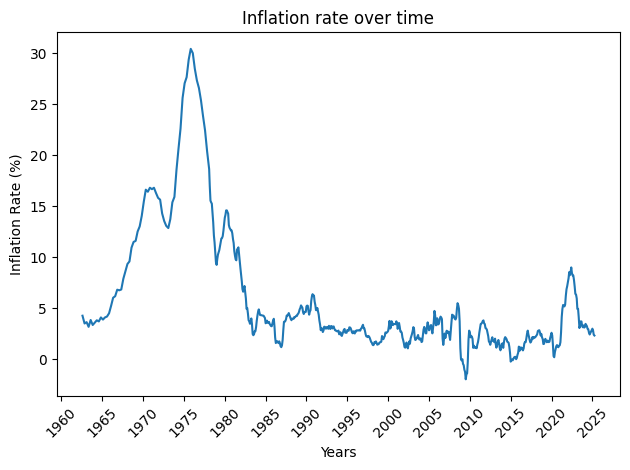

In [ ]:
plt.plot(df.index, df.inflation_rate)
plt.title("Inflation rate over time")
plt.xlabel("Years")
plt.ylabel("Inflation Rate (%)")
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))  # every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The highest peak is between period of 1975-1980, the other peak happens during Covid

In [ ]:
filter_df=df.resample('Y').max().sort_values('inflation_rate', ascending=False).loc[:,['inflation_rate']]
filter_df.loc[filter_df.index>'1991'].head()

<ipython-input-195-e529023ef818>:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  filter_df=df.resample('Y').max().sort_values('inflation_rate', ascending=False).loc[:,['inflation_rate']]


,inflation_rate
Date,
2022-12-31,9.00
2021-12-31,7.16
2023-12-31,6.34
1991-12-31,5.65
2008-12-31,5.50


### Inflation Serial Correlation

**lags**: correlation for time series observations with observations with previous time steps. \
Lag 1 = comparing each value in the time series to the value immediately before it \
In the autocorrelation correction plot, xonfidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, correlation values outside of this code are very likely a significant correlation.

Question: Does inflation rate (by year) serially correlated? Can we predict inflation by looking at inflation rate of previous years?

<ipython-input-249-c3ab675663c9>:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  plot_acf(df.resample('Y').median().dropna().inflation_rate, lags=5)


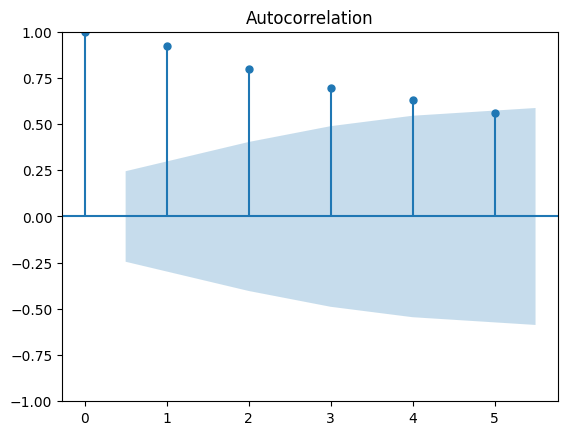

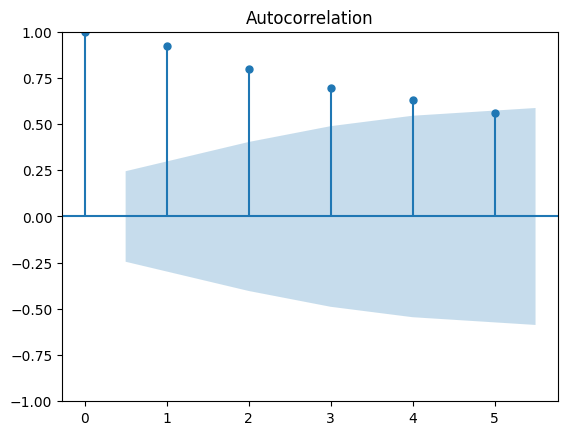

In [ ]:
plot_acf(df.resample('Y').median().dropna().inflation_rate, lags=5)

Verticle bar at lag value 1,2,3 4 is outside confidence region, suggesting that inflation rate of 4 years are correlated

Hypothese: Does inflation rate by month serially correlated? Can we predict inflation by looking at inflation rate of previous month?

In [ ]:
df_=df.copy()
df_['inflation'] = df.CPIAUCSL.pct_change()*100
# df_['inflation_corr'] =df_['inflation'].autocorr(lag=1) #Lag-1 refers to comparing each value in a time series to the one immediately before it — that is, one period earlier.
df_.head(2)

,UNRATE,CIVPART,PAYEMS,FEDFUNDS,M2SL,HOUST,UMCSENT,WTISPLC,PPIACO,PCEPI,PCEPILFE,CPIAUCSL,CPILFESL,inflation_rate,inflation
Date,,,,,,,,,,,,,,,
1959-05-01,5.1,59.2,53550.0,2.9,292.2,1498.0,95.3,2.97,31.8,15.227,15.589,29.04,30.1,NaN,NaN
1959-11-01,5.8,59.1,53634.0,4.0,297.1,1416.0,93.8,2.97,31.5,15.412,15.794,29.35,30.4,NaN,1.067493


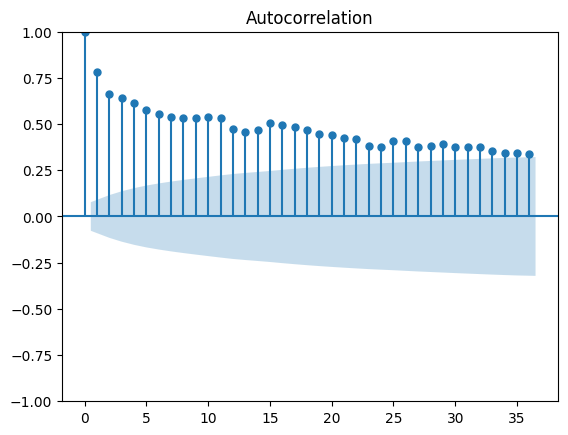

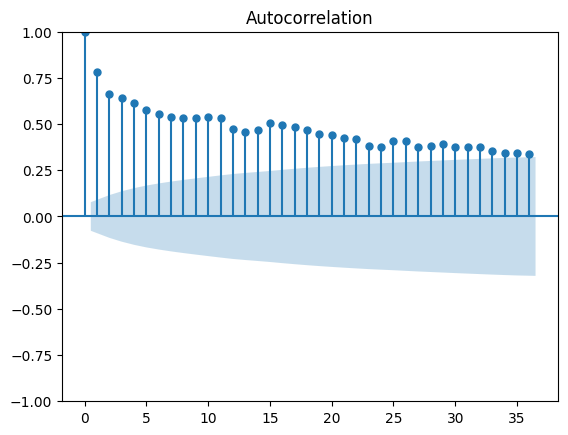

In [ ]:
plot_acf(df_.inflation.dropna(), lags=36)


Verticle bar of lags=1 to lags=30 is out of confidence region

Interpretation of ACF plot: inflation rate for one months is close

## B. What factors affect inflation rate

### Using Heatmap to show how variables correlate

In [34]:
df.head(2)

,UNRATE,CIVPART,PAYEMS,FEDFUNDS,M2SL,HOUST,UMCSENT,WTISPLC,PPIACO,PCEPI,PCEPILFE,CPIAUCSL,CPILFESL,inflation_rate,PPIACO_rate,MoneySupply_rate,oilprice_rate
Date,,,,,,,,,,,,,,,,,
1959-05-01,5.1,59.2,53550.0,2.9,292.2,1498.0,95.3,2.97,31.8,15.227,15.589,29.04,30.1,NaN,NaN,NaN,NaN
1959-11-01,5.8,59.1,53634.0,4.0,297.1,1416.0,93.8,2.97,31.5,15.412,15.794,29.35,30.4,NaN,NaN,NaN,NaN


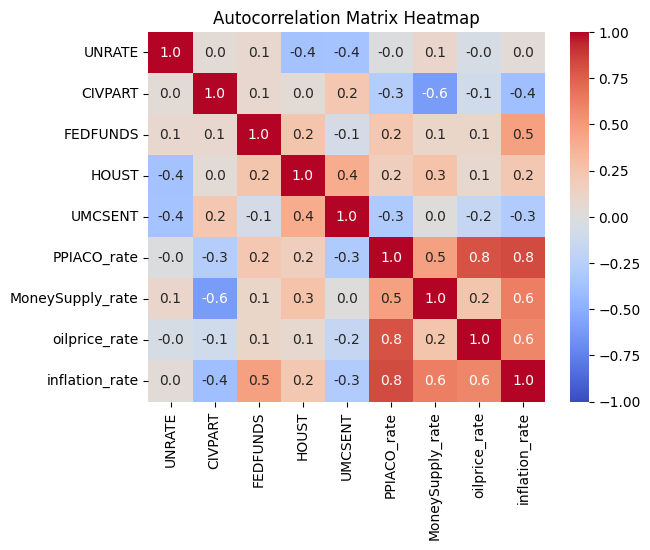

In [35]:
df_=df[~df.inflation_rate.isna()][['UNRATE','CIVPART', 'FEDFUNDS', 'HOUST', 'UMCSENT',"PPIACO_rate","MoneySupply_rate", "oilprice_rate","inflation_rate"]]

correlation_matrix = df_.corr()
# create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", vmin=-1, vmax=1)
plt.title('Autocorrelation Matrix Heatmap')
plt.show()

inflation rate is strongly correlated with oil_price, moneysupply, PPIACO, FEDFUNS,

### Cross Correlation

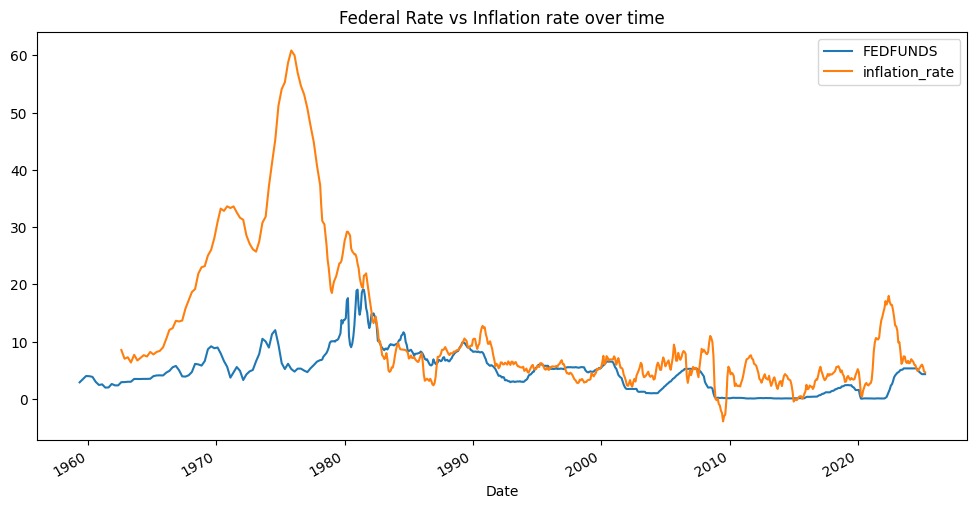

In [36]:
df[['FEDFUNDS', 'inflation_rate']].plot(figsize=(12, 6))
plt.title("Federal Rate vs Inflation rate over time")
plt.show()

Does inflation happen after or before a change in FedFund rate?

We know that change in FedFund on inflation is not immediate, there is typically a lag. \
We check this lag using cross correlation \
correlation higher 0.7 mean fedrate and inflation move forward in the same direction

In [37]:
df_=df[~df.inflation_rate.isna()]
df_.shape

(630, 17)

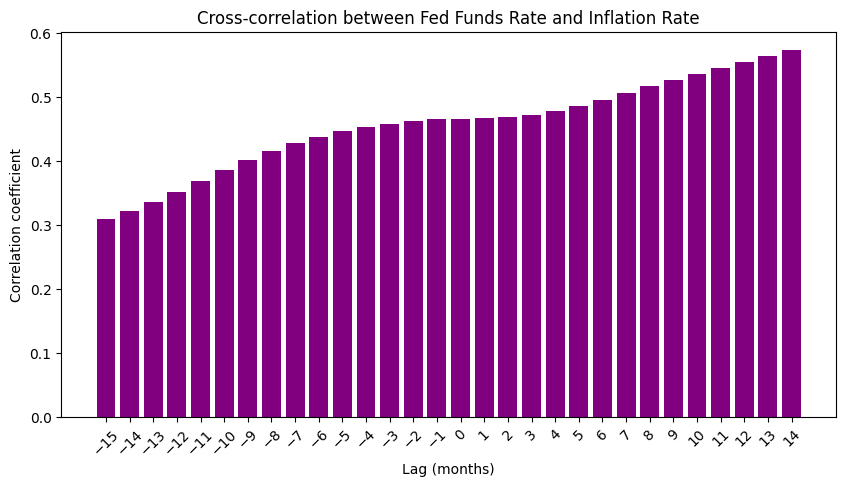

In [40]:
lags = range(-15, 15)  # lag of ±24 months
cross_cors = [df_['FEDFUNDS'].corr(df_['inflation_rate'].shift(lag)) for lag in lags]
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(lags, cross_cors, color='purple')
ax.set_title('Cross-correlation between Fed Funds Rate and Inflation Rate')
ax.set_xlabel('Lag (months)')
ax.set_ylabel('Correlation coefficient')
# ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xticks(lags)
ax.tick_params(axis='x', labelrotation=45)

plt.show()

In [41]:
df.head()

,UNRATE,CIVPART,PAYEMS,FEDFUNDS,M2SL,HOUST,UMCSENT,WTISPLC,PPIACO,PCEPI,PCEPILFE,CPIAUCSL,CPILFESL,inflation_rate,PPIACO_rate,MoneySupply_rate,oilprice_rate
Date,,,,,,,,,,,,,,,,,
1959-05-01,5.1,59.2,53550.0,2.90,292.2,1498.0,95.3,2.97,31.8,15.227,15.589,29.04,30.1,NaN,NaN,NaN,NaN
1959-11-01,5.8,59.1,53634.0,4.00,297.1,1416.0,93.8,2.97,31.5,15.412,15.794,29.35,30.4,NaN,NaN,NaN,NaN
1960-02-01,4.8,59.1,54513.0,3.97,298.4,1503.0,100.0,2.97,31.6,15.437,15.852,29.41,30.6,NaN,NaN,NaN,NaN
1960-05-01,5.1,59.5,54475.0,3.85,300.9,1271.0,93.3,2.97,31.7,15.518,15.908,29.57,30.6,NaN,NaN,NaN,NaN
1960-08-01,5.6,59.5,54272.0,2.98,306.9,1344.0,97.2,2.97,31.6,15.579,15.968,29.61,30.6,NaN,NaN,NaN,NaN


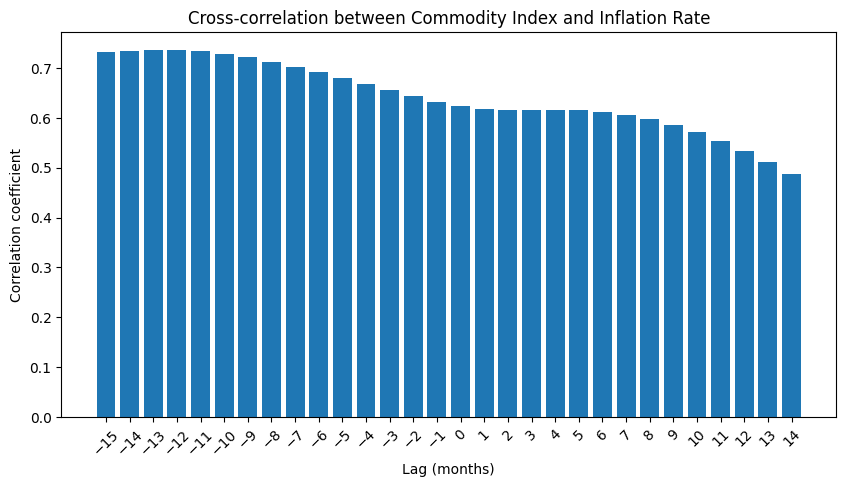

In [44]:
lags = range(-15, 15)  # lag of ±24 months
cross_cors = [df_['MoneySupply_rate'].corr(df_['inflation_rate'].shift(lag)) for lag in lags]
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(lags, cross_cors)
ax.set_title('Cross-correlation between Money Supply Rate and Inflation Rate')
ax.set_xlabel('Lag (months)')
ax.set_ylabel('Correlation coefficient')
# ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xticks(lags)
ax.tick_params(axis='x', labelrotation=45)

plt.show()

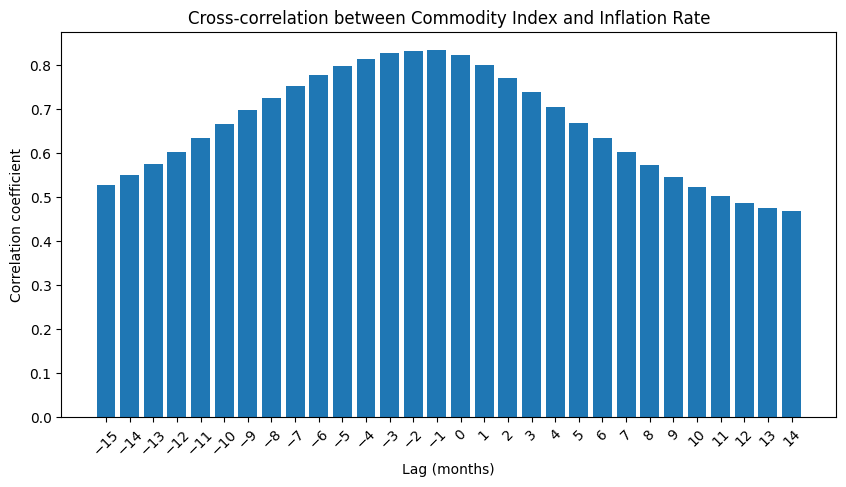

In [43]:
lags = range(-15, 15)  # lag of ±24 months
cross_cors = [df_['PPIACO_rate'].corr(df_['inflation_rate'].shift(lag)) for lag in lags]
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(lags, cross_cors)
ax.set_title('Cross-correlation between Commodity Index and Inflation Rate')
ax.set_xlabel('Lag (months)')
ax.set_ylabel('Correlation coefficient')
# ax.xaxis.set_major_locator(MultipleLocator(1))
ax.set_xticks(lags)
ax.tick_params(axis='x', labelrotation=45)

plt.show()

correlation peaks at lag=-1 => the commodities prices rise and drop with the inflation rate by 1 month period, which given that both the inflation rate and commodities price index measure prices, this relationship makes sense

## Inflation Prediction

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## ideas
Returning to a pre-pandemic housing market
 in unemployemnt ,what population is affected the most
 what state is affected the most
 https://fredblog.stlouisfed.org/2025/06/returning-to-a-pre-pandemic-housing-market/